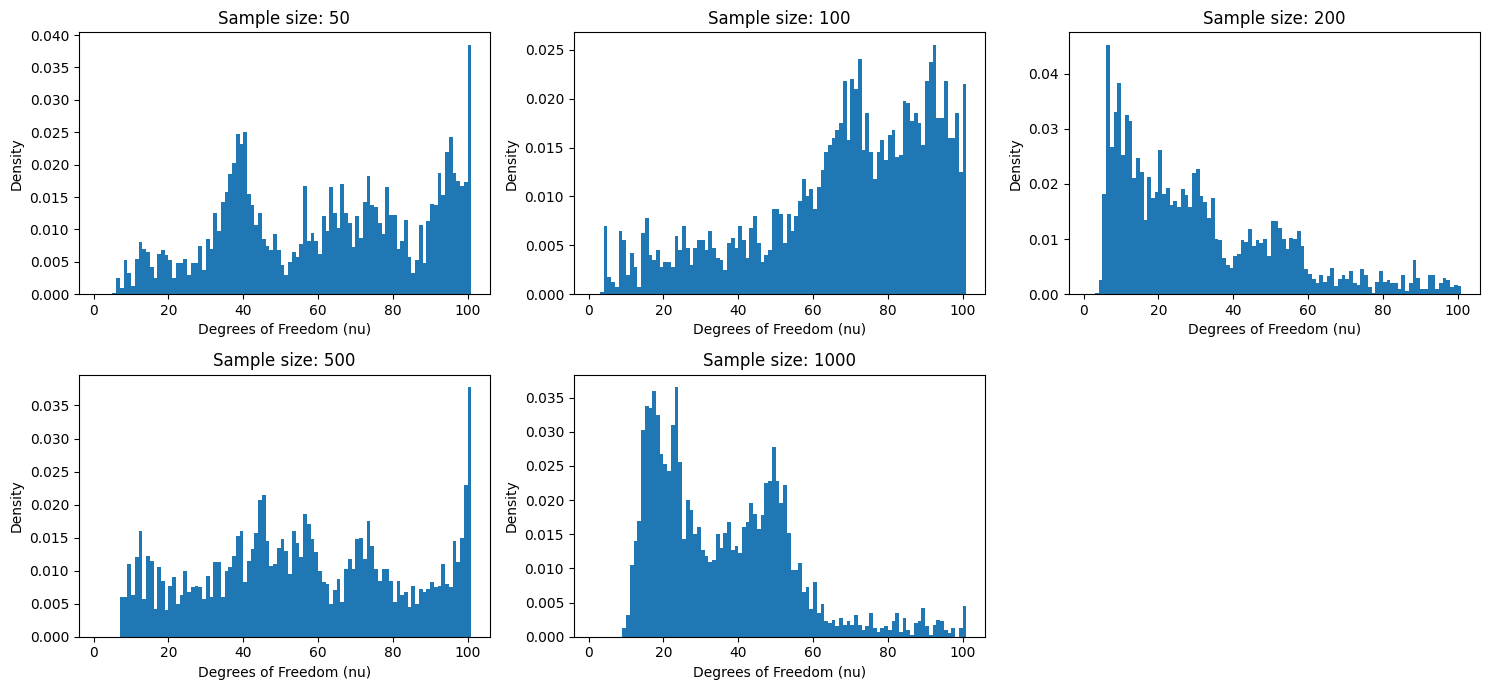

In [16]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

loc_true, scale_true, df_true = 10, 2, 15
mu_0, sigma_0 = 0, 10

sample_sizes = [50, 100, 200, 500, 1000]


nu_traces = {}

traces = {}

for n in sample_sizes:
    x = np.random.standard_t(df=df_true, size=n) * scale_true + loc_true

    with pm.Model() as model:
        # Priors
        mu = pm.Normal('mu', mu=mu_0, sigma=sigma_0)
        tau_sq = pm.HalfNormal('tau_sq', sigma=5)
        nu = pm.DiscreteUniform('nu', lower=1, upper=101)

        # Likelihood
        pm.StudentT('likelihood', nu=nu, mu=mu, lam=1/tau_sq, observed=x)

        # Sampling
        trace1 = pm.sample(2000, tune=1000, return_inferencedata=True, progressbar=False)
        trace = pm.sample(2000, tune=1000, return_inferencedata=False, progressbar=False)
    traces[n] = trace1
    nu_traces[n] = trace['nu']

plt.figure(figsize=(15, 7))

for i, n in enumerate(sample_sizes):
    plt.subplot(2, 3, i+1)
    plt.hist(nu_traces[n], bins=range(1, 102), density=True)
    plt.title(f'Sample size: {n}')
    plt.xlabel('Degrees of Freedom (nu)')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()


The histograms show the posterior distributions of the degrees of freedom  ($\nu$) for the t-distribution, across different sample sizes.

With a sample size of 50, the histogram shows a very wide and somewhat uniform distribution across the range of possible values for $\nu$. There is no clear peak, which suggests that the data does not provide strong evidence to favor any particular value of
$\nu$, thus indicating a high degree of uncertainty in the estimate.

At a sample size of 200, the histogram begins to show a more pronounced peak at lower values, with the distribution tapering off as
$\nu$ increases. This peak suggests that the data is starting to provide more information about the degrees of freedom, potentially indicating a preference for a t-distribution with a specific range of
$\nu$, which corresponds to heavier tails than a normal distribution.

When the sample size is further increased to 500, the histogram becomes more concentrated around a particular range of
$\nu$ values, showing that the posterior distribution is becoming tighter. This implies that the inference about the degrees of freedom is getting more precise with larger samples, which allows for a more confident estimation of the tail behavior in the underlying distribution of the data.

Finally, at a sample size of 1000, the histogram exhibits a clear peak and a much narrower spread of
$\nu$ values, indicating that the model is now much more certain about the degrees of freedom parameter. The data at this size provides strong evidence to support a particular range of
$\nu$, suggesting that the tails of the distribution are well-characterized by this range of
$\nu$.

As the sample size increases, the posterior distribution for the degrees of freedom parameter $\nu$ becomes progressively narrower, indicating more precise and confident inference.

In [21]:
import arviz as az

for n in sample_sizes:
    idata = traces[n]

    summary = az.summary(idata, round_to=2)

    ess_bulk = summary['ess_bulk'].values
    r_hat = summary['r_hat'].values
    divergences = idata.sample_stats['diverging'].values.sum()
    acceptance_rates = idata.sample_stats['acceptance_rate'].values.mean()

    print(f"Sample size: {n}")
    print(f"Effective Sample Sizes:\n{ess_bulk}")
    print(f"Chain Convergence (R-hat):\n{r_hat}")
    print(f"Divergences: {divergences}")
    print(f"Mean Acceptance Probability: {acceptance_rates}\n")

Sample size: 50
Effective Sample Sizes:
[4002.05    8.82 1150.35]
Chain Convergence (R-hat):
[1.   1.17 1.01]
Divergences: 0
Mean Acceptance Probability: 0.8297623156389512

Sample size: 100
Effective Sample Sizes:
[3507.37    6.33 2270.33]
Chain Convergence (R-hat):
[1.   1.24 1.01]
Divergences: 0
Mean Acceptance Probability: 0.8254639850924177

Sample size: 200
Effective Sample Sizes:
[3284.84    7.55   17.28]
Chain Convergence (R-hat):
[1.   1.22 1.08]
Divergences: 0
Mean Acceptance Probability: 0.8197972835330413

Sample size: 500
Effective Sample Sizes:
[3288.24   11.01   40.99]
Chain Convergence (R-hat):
[1.   1.14 1.04]
Divergences: 0
Mean Acceptance Probability: 0.7971423839373734

Sample size: 1000
Effective Sample Sizes:
[2910.29    3.24   15.23]
Chain Convergence (R-hat):
[1.   1.68 1.09]
Divergences: 0
Mean Acceptance Probability: 0.8412359703967945



In [25]:
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

with pm.Model() as Centered_eight:

    # We assume the following prior distributions for our parameters
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)

    # and we assume the following probabilistic hierarchy
    # within the data generating mechanism
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J) # theta is length J=8

    # Note that if tau was small, then the density evalution above
    # could change rapidly for changes in theta
    # This means that the energy has high curvature

    # likelihood where observed information enters into the model
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

SEED = [20100420, 20134234] # random seeds for each of two run HMC chains


with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})



with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    # Changes in theta now take place on a fixed scale that is independent of tau

    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    # Changes in tau can still result in rapid changes in the density evaluations
    # below so the energy still has high curvature with respect to tau; but,
    # it no longer has high curvature with respect to theta
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)


with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})

In [27]:
idata_C = fit_C
idata_NC = fit_NC

summary_C = az.summary(idata_C, round_to=2)
ess_C = summary_C['ess_bulk']
r_hat_C = summary_C['r_hat']
divergences_C = idata_C.sample_stats['diverging'].sum().item()
acceptance_rates_C = idata_C.sample_stats['acceptance_rate'].mean().item()

summary_NC = az.summary(idata_NC, round_to=2)
ess_NC = summary_NC['ess_bulk']
r_hat_NC = summary_NC['r_hat']
divergences_NC = idata_NC.sample_stats['diverging'].sum().item()
acceptance_rates_NC = idata_NC.sample_stats['acceptance_rate'].mean().item()

print("Centered Model Diagnostics:")
print(f"Effective Sample Sizes:\n{ess_C}")
print(f"Chain Convergence (R-hat):\n{r_hat_C}")
print(f"Divergences: {divergences_C}")
print(f"Mean Acceptance Rate: {acceptance_rates_C}\n")

print("Uncentered Model Diagnostics:")
print(f"Effective Sample Sizes:\n{ess_NC}")
print(f"Chain Convergence (R-hat):\n{r_hat_NC}")
print(f"Divergences: {divergences_NC}")
print(f"Mean Acceptance Rate: {acceptance_rates_NC}")

Centered Model Diagnostics:
Effective Sample Sizes:
mu           622.77
theta[0]     538.46
theta[1]     978.36
theta[2]    1575.05
theta[3]     964.74
theta[4]    1673.49
theta[5]    1769.35
theta[6]     415.23
theta[7]    1248.42
tau          128.66
Name: ess_bulk, dtype: float64
Chain Convergence (R-hat):
mu          1.01
theta[0]    1.01
theta[1]    1.00
theta[2]    1.00
theta[3]    1.00
theta[4]    1.00
theta[5]    1.00
theta[6]    1.01
theta[7]    1.00
tau         1.02
Name: r_hat, dtype: float64
Divergences: 354
Mean Acceptance Rate: 0.6879946205490247

Uncentered Model Diagnostics:
Effective Sample Sizes:
mu            11120.12
theta_t[0]    12332.60
theta_t[1]    13263.21
theta_t[2]    15199.46
theta_t[3]    14951.30
theta_t[4]    14707.69
theta_t[5]    13359.94
theta_t[6]    11562.53
theta_t[7]    15762.83
tau            5121.40
theta[0]      10859.36
theta[1]      11964.60
theta[2]      11070.59
theta[3]      12522.79
theta[4]      11293.55
theta[5]      10616.01
theta[6]   

In the "centered" model, the effective sample sizes (ESS) for the parameters, particularly for tau, are relatively low, and the R-hat values are above the ideal 1.0 threshold for some parameters, which indicates potential issues with convergence. The high number of divergences (354) suggests that the sampler frequently encounters regions of high curvature in the posterior distribution, which is problematic for HMC. These regions of high curvature can result from the dependency between the school effects (theta) and the hyperparameter tau. When tau is close to zero, small changes in theta can lead to large changes in the posterior density, creating a "funnel" shape that is difficult for the sampler to navigate. This can result in inefficient sampling and a high number of divergences as the sampler struggles to adapt to the varying curvature.

On the other hand, the "uncentered" model shows much better diagnostics. The ESS values are an order of magnitude larger, indicating that the sampler is able to explore the posterior distribution more effectively and generate more independent samples. The R-hat values are at the ideal 1.0 across all parameters, signifying good convergence of the chains. The number of divergences is drastically reduced to only 8, and the mean acceptance rate is higher (approximately 0.83), indicating that the sampler's proposals are more often in regions of the posterior distribution that have consistent curvature and are thus accepted more frequently.

The "uncentered" model reparametrizes the school effects and the hyperparameter tau in such a way that it reduces the interdependence between them. This flattens the "funnel" and results in a posterior distribution with less extreme curvature, which is easier for the HMC algorithm to explore. This is why the "uncentered" parametrization performs better: it avoids the problematic geometry that makes sampling difficult in the "centered" version.

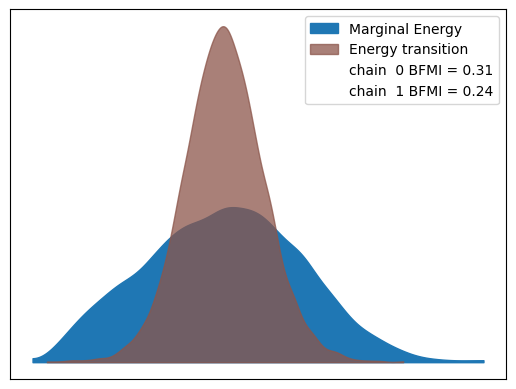

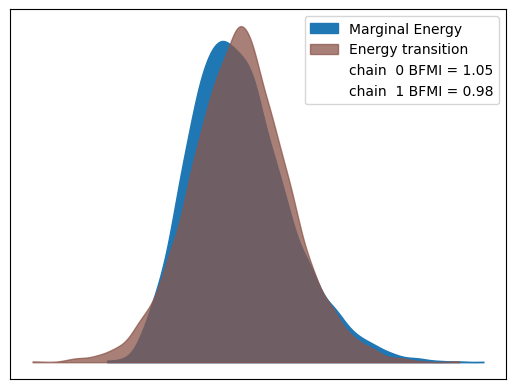

In [28]:
az.plot_energy(fit_C);
az.plot_energy(fit_NC);


In the first plot for the "centered" model, there is a noticeable discrepancy between the marginal and transition energy distributions. The BFMI is above 1 for one of the chains, which is unusual and indicates a potential issue. A BFMI close to 1 or higher suggests that the energy levels during the transition are not matching well with the overall energy distribution, implying that the sampler may be struggling with the geometry of the target distribution. This could be due to the "funnel" problem in the "centered" parameterization, where the sampler finds it challenging to move efficiently through areas with varying curvature.

In the second plot for the "uncentered" model, the BFMI values are much lower. The overlap between the marginal and transition energy distributions is much better, indicating that the energy proposals during sampling are well-aligned with the empirical energy distribution. This indicates efficient exploration of the posterior distribution by the HMC algorithm, with fewer signs of the sampler getting stuck or struggling with the target distribution's geometry.